In [14]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel

# Estilo para os gráficos
sns.set(style="whitegrid", font_scale=1.1)

In [7]:
# Substitua o caminho caso os arquivos estejam em outro diretório
with open("/Users/gustavolgcr/doutorado/implementacoes/experiments/src/results/evaluation_results_icl_with_repetitions_torcedor.json", "r", encoding="utf-8") as f:
    dados_torcedor = json.load(f)

with open("/Users/gustavolgcr/doutorado/implementacoes/experiments/src/results/evaluation_results_icl_with_repetitions_tecnico.json", "r", encoding="utf-8") as f:
    dados_tecnico = json.load(f)

In [8]:
def expand_icl_data(dados, perfil):
    linhas = []
    for exemplo in dados:
        for i in range(len(exemplo["scores_zero_shot"])):
            linhas.append({
                "pergunta": exemplo["pergunta"],
                "perfil": perfil,
                "criterio": exemplo["criterio"],
                "repeticao": i + 1,
                "zero_shot": exemplo["scores_zero_shot"][i],
                "one_shot": exemplo["scores_one_shot"][i],
                "few_shot": exemplo["scores_few_shot"][i],
            })
    return pd.DataFrame(linhas)

df_torcedor = expand_icl_data(dados_torcedor, "Torcedor")
df_tecnico = expand_icl_data(dados_tecnico, "Técnico")

df = pd.concat([df_torcedor, df_tecnico], ignore_index=True)

In [10]:
df.shape

(1400, 7)

In [13]:
resultados_teste = []

for perfil in df["perfil"].unique():
    for criterio in df["criterio"].unique():
        subset = df[(df["perfil"] == perfil) & (df["criterio"] == criterio)]

        stat_1, p_1 = ttest_rel(subset["zero_shot"], subset["one_shot"])
        stat_2, p_2 = ttest_rel(subset["zero_shot"], subset["few_shot"])
        stat_3, p_3 = ttest_rel(subset["one_shot"], subset["few_shot"])

        resultados_teste.append({
            "Perfil": perfil,
            "Critério": criterio,
            "Zero vs One (p)": round(p_1, 4),
            "Zero vs Few (p)": round(p_2, 4),
            "One vs Few (p)": round(p_3, 4),
            "Significativo Z↔O": "✅" if p_1 < 0.05 else "❌",
            "Significativo Z↔F": "✅" if p_2 < 0.05 else "❌",
            "Significativo O↔F": "✅" if p_3 < 0.05 else "❌",
        })

df_resultado = pd.DataFrame(resultados_teste)
df_resultado

,Perfil,Critério,Zero vs One (p),Zero vs Few (p),One vs Few (p),Significativo Z↔O,Significativo Z↔F,Significativo O↔F
0,Torcedor,AdequacaoAoPerfil,0.0000,0.000,0.0000,✅,✅,✅
1,Torcedor,UsoDeInformacoesRelevantes,0.0000,0.000,0.0000,✅,✅,✅
2,Torcedor,TomEEstiloAdequado,0.0000,0.000,0.0000,✅,✅,✅
3,Torcedor,ClarezaNaComunicacao,0.0000,0.000,0.0000,✅,✅,✅
4,Torcedor,PersonalizacaoExplicita,0.0017,0.000,0.8677,✅,✅,❌
5,Torcedor,SelecaoDeDadosRelevantes,0.0000,0.000,0.0000,✅,✅,✅
6,Torcedor,AusenciaDeAlucinacoes,0.0000,0.533,0.0000,✅,❌,✅
7,Técnico,AdequacaoAoPerfil,0.2713,0.000,0.0000,❌,✅,✅
8,Técnico,UsoDeInformacoesRelevantes,0.0050,0.000,0.0000,✅,✅,✅
9,Técnico,TomEEstiloAdequado,0.0050,0.000,0.0088,✅,✅,✅


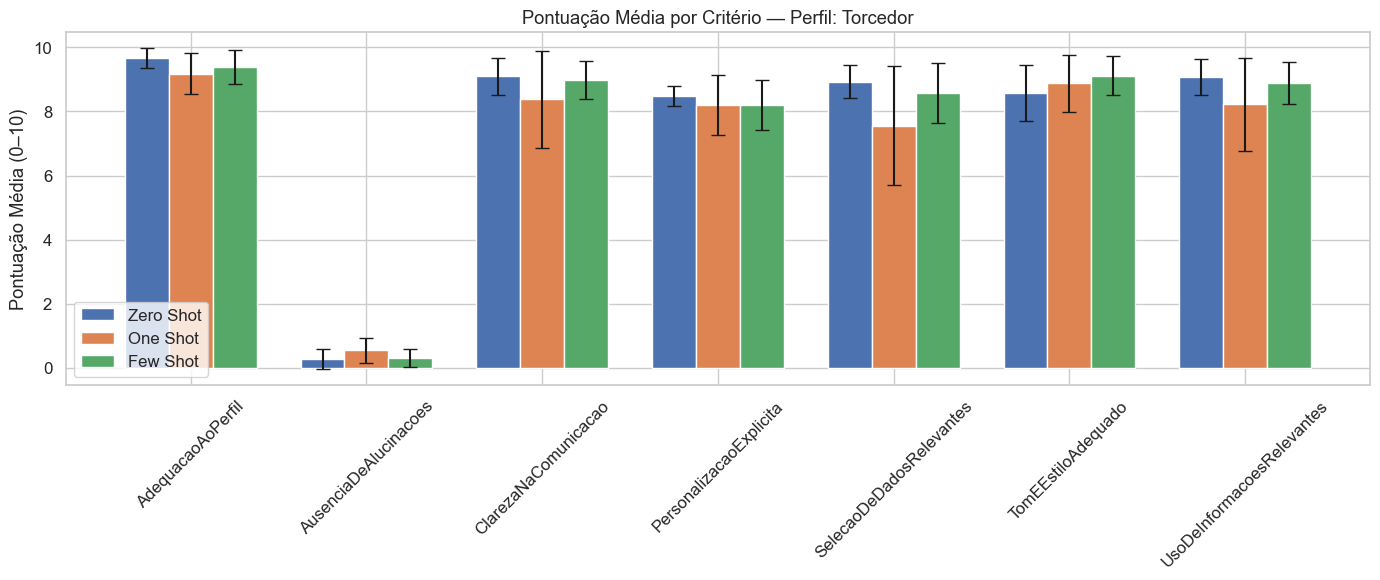

In [15]:
df_agg = df.groupby(["perfil", "criterio"])[["zero_shot", "one_shot", "few_shot"]].agg(["mean", "std"]).reset_index()
df_agg.columns = ["perfil", "criterio",
                  "ZeroShot_Média", "ZeroShot_DP",
                  "OneShot_Média", "OneShot_DP",
                  "FewShot_Média", "FewShot_DP"]

# Exemplo para perfil Torcedor
dados_torcedor = df_agg[df_agg["perfil"] == "Torcedor"]

x = np.arange(len(dados_torcedor["criterio"]))
largura = 0.25

fig, ax = plt.subplots(figsize=(14, 6))
ax.bar(x - largura, dados_torcedor["ZeroShot_Média"], width=largura, yerr=dados_torcedor["ZeroShot_DP"], capsize=5, label="Zero Shot")
ax.bar(x, dados_torcedor["OneShot_Média"], width=largura, yerr=dados_torcedor["OneShot_DP"], capsize=5, label="One Shot")
ax.bar(x + largura, dados_torcedor["FewShot_Média"], width=largura, yerr=dados_torcedor["FewShot_DP"], capsize=5, label="Few Shot")

ax.set_xticks(x)
ax.set_xticklabels(dados_torcedor["criterio"], rotation=45)
ax.set_ylabel("Pontuação Média (0–10)")
ax.set_title("Pontuação Média por Critério — Perfil: Torcedor")
ax.legend()
plt.tight_layout()
plt.show()

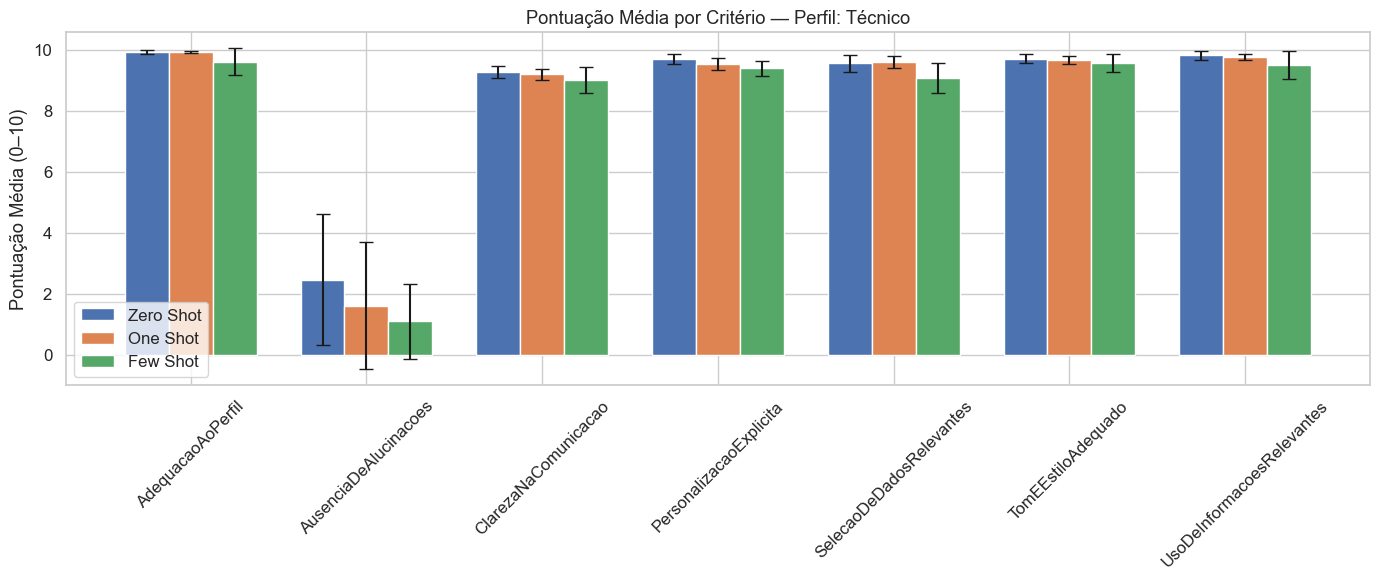

In [31]:
# Exemplo para perfil Torcedor
dados_tecnico = df_agg[df_agg["perfil"] == "Técnico"]

x = np.arange(len(dados_tecnico["criterio"]))
largura = 0.25

fig, ax = plt.subplots(figsize=(14, 6))
ax.bar(x - largura, dados_tecnico["ZeroShot_Média"], width=largura, yerr=dados_tecnico["ZeroShot_DP"], capsize=5, label="Zero Shot")
ax.bar(x, dados_tecnico["OneShot_Média"], width=largura, yerr=dados_tecnico["OneShot_DP"], capsize=5, label="One Shot")
ax.bar(x + largura, dados_tecnico["FewShot_Média"], width=largura, yerr=dados_tecnico["FewShot_DP"], capsize=5, label="Few Shot")

ax.set_xticks(x)
ax.set_xticklabels(dados_tecnico["criterio"], rotation=45)
ax.set_ylabel("Pontuação Média (0–10)")
ax.set_title("Pontuação Média por Critério — Perfil: Técnico")
ax.legend()
plt.tight_layout()
plt.show()

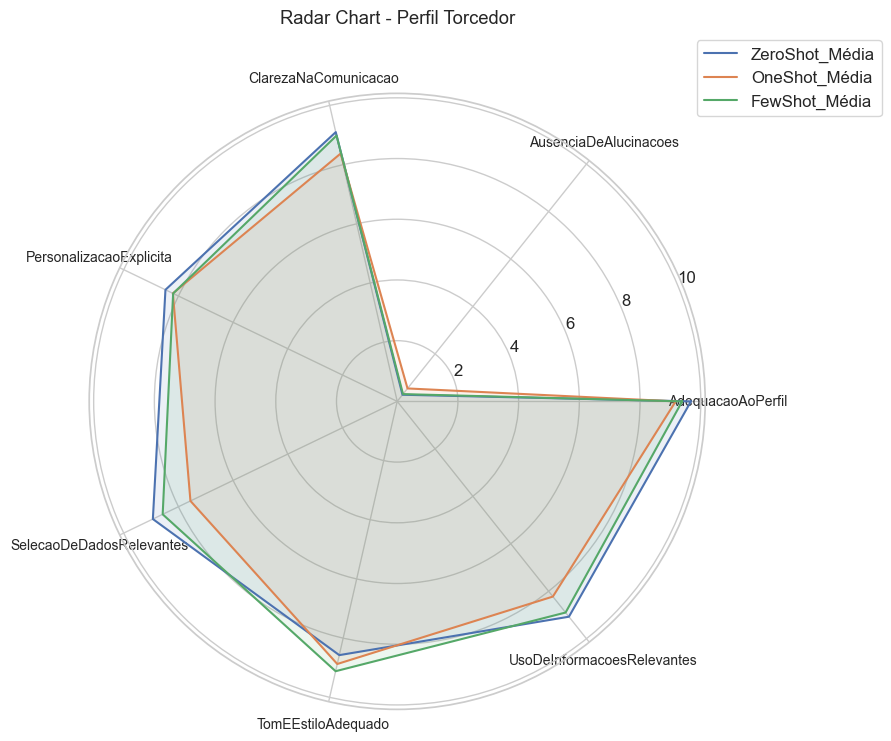

In [27]:
from math import pi
import matplotlib.pyplot as plt

# Converter para estrutura adequada
radar_data = dados_torcedor.set_index("criterio")[["ZeroShot_Média", "OneShot_Média", "FewShot_Média"]].T
categorias = radar_data.columns.tolist()  # ✅ sem duplicar

# Ângulos para o radar
angles = [n / float(len(categorias)) * 2 * pi for n in range(len(categorias))]
angles += [angles[0]]  # Fechar o círculo nos ângulos

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
for i, row in radar_data.iterrows():
    valores = row.tolist()
    valores += [valores[0]]  # Fechar círculo nos valores
    ax.plot(angles, valores, label=i)
    ax.fill(angles, valores, alpha=0.1)

ax.set_xticks(angles[:-1])  # os ângulos das categorias
ax.set_xticklabels(categorias, fontsize=10)
ax.set_title("Radar Chart - Perfil Torcedor", y=1.1)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()

In [ ]:
import pandas as pd
from evaluate import load
from rapidfuzz.distance import Levenshtein
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import jaccard_score

# Métricas do HuggingFace Evaluate
bertscore = load("bertscore")
rouge = load("rouge")
bleu = load("bleu")

In [29]:
def jaccard_similarity(str1, str2):
    vec = CountVectorizer(binary=True).fit([str1, str2])
    x = vec.transform([str1]).toarray()
    y = vec.transform([str2]).toarray()
    return jaccard_score(x[0], y[0])

def get_metrics(text1, text2):
    metrics = {}

    # BERTScore
    bs = bertscore.compute(predictions=[text1], references=[text2], lang="en")
    metrics["BERTScore"] = round(bs["f1"][0], 4)

    # ROUGE
    r = rouge.compute(predictions=[text1], references=[text2], rouge_types=["rougeL"])
    metrics["ROUGE_L"] = round(r["rougeL"], 4)

    # BLEU – corrigido aqui
    b = bleu.compute(predictions=[text1], references=[text2])
    metrics["BLEU"] = round(b["bleu"], 4)

    # Jaccard
    try:
        metrics["Jaccard"] = round(jaccard_similarity(text1, text2), 4)
    except ValueError:
        metrics["Jaccard"] = 0.0
    except Exception as e:
        print(f"An error occurred while calculating Jaccard similarity: {e}")
        metrics["Jaccard"] = 0.0

    # Edit Distance
    dist = Levenshtein.normalized_distance(text1, text2)
    metrics["Edit_Dist"] = round(1 - dist, 4)

    return metrics

In [22]:
with open("/Users/gustavolgcr/doutorado/implementacoes/experiments/src/data/questions_and_answers_icl_torcedor.json", "r", encoding="utf-8") as f:
    respostas_torcedor = json.load(f)

with open("/Users/gustavolgcr/doutorado/implementacoes/experiments/src/data/questions_and_answers_icl_tecnico.json", "r", encoding="utf-8") as f:
    respostas_tecnico = json.load(f)

In [23]:
def gerar_comparacoes_variacao(dados, perfil):
    linhas = []
    for exemplo in dados:
        pergunta = exemplo["pergunta"]
        res_zero = exemplo["resposta_zero_shot"]
        res_one = exemplo["resposta_one_shot"]
        res_few = exemplo["resposta_few_shot"]

        for par, t1, t2 in [
            ("Zero vs One", res_zero, res_one),
            ("Zero vs Few", res_zero, res_few),
            ("One vs Few", res_one, res_few),
        ]:
            metrics = get_metrics(t1, t2)
            metrics["par"] = par
            metrics["pergunta"] = pergunta
            metrics["perfil"] = perfil
            linhas.append(metrics)

    return pd.DataFrame(linhas)

df_var_torcedor = gerar_comparacoes_variacao(respostas_torcedor, "Torcedor")
df_var_tecnico = gerar_comparacoes_variacao(respostas_tecnico, "Técnico")
df_variacao = pd.concat([df_var_torcedor, df_var_tecnico], ignore_index=True)

df_variacao.head()

,BERTScore,ROUGE_L,BLEU,Jaccard,Edit_Dist,par,pergunta,perfil
0,0.9165,0.5046,0.4053,0.4886,0.4615,Zero vs One,Bruno Pacheco foi bem no jogo contra o Ceará n...,Torcedor
1,0.9210,0.5581,0.4427,0.5060,0.5000,Zero vs Few,Bruno Pacheco foi bem no jogo contra o Ceará n...,Torcedor
2,0.9169,0.5148,0.4508,0.4681,0.5041,One vs Few,Bruno Pacheco foi bem no jogo contra o Ceará n...,Torcedor
3,0.8752,0.3636,0.2175,0.3418,0.3745,Zero vs One,Qual jogador do Fortaleza correu mais rápido d...,Torcedor
4,0.9006,0.5625,0.3322,0.4648,0.4841,Zero vs Few,Qual jogador do Fortaleza correu mais rápido d...,Torcedor


In [24]:
agrupado = df_variacao.groupby(["perfil", "par"]).mean(numeric_only=True).round(4)
agrupado.reset_index(inplace=True)
agrupado

,perfil,par,BERTScore,ROUGE_L,BLEU,Jaccard,Edit_Dist
0,Torcedor,One vs Few,0.8973,0.4644,0.3179,0.3942,0.4174
1,Torcedor,Zero vs Few,0.8949,0.4651,0.2935,0.3931,0.4337
2,Torcedor,Zero vs One,0.8891,0.3950,0.2506,0.3691,0.4065
3,Técnico,One vs Few,0.9083,0.4661,0.3522,0.4216,0.4619
4,Técnico,Zero vs Few,0.8879,0.4114,0.2642,0.3655,0.3966
5,Técnico,Zero vs One,0.8915,0.4478,0.3287,0.4102,0.4117


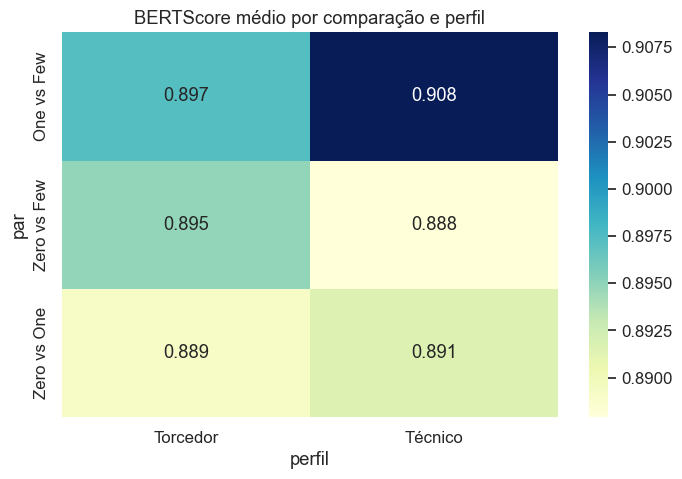

In [25]:
pivot = agrupado.pivot(index="par", columns="perfil", values="BERTScore")

plt.figure(figsize=(8, 5))
sns.heatmap(pivot, annot=True, cmap="YlGnBu", fmt=".3f")
plt.title("BERTScore médio por comparação e perfil")
plt.show()

# Análise

🔍 1. Análise dos Resultados do G-Eval (Qualidade da Resposta)

Perfil: Torcedor do Time

Gráfico: Barras com média e desvio padrão por critério
	•	Adequação ao Perfil: Todas as abordagens pontuaram bem. Zero-shot foi ligeiramente superior, indicando que mesmo sem exemplos, a estrutura da resposta já atende bem às expectativas do torcedor.
	•	Ausência de Alucinações: Baixíssimo em todas as abordagens, mas com Zero-shot levemente melhor. Isso sugere que o uso de exemplos no prompt não está ajudando a evitar invenções, e possivelmente está até induzindo informações extras.
	•	Tom e Estilo Adequado / Personalização Explícita: Pouca variação entre abordagens. Few-shot foi discretamente melhor, o que pode indicar um leve ganho na adaptação do tom.
	•	Seleção e Uso de Dados Relevantes: Few-shot e Zero-shot tiveram melhor desempenho que o One-shot. Pode indicar que apenas um exemplo não é suficiente para alterar o foco da resposta.

Perfil: Técnico do Time

Gráfico: Barras com média e desvio padrão por critério
	•	Adequação ao Perfil / Clareza / Tom Técnico: Altas pontuações em todas as abordagens. Zero-shot e One-shot lideram.
	•	Ausência de Alucinações: Melhor em Zero-shot, com declínio visível em Few-shot. Isso sugere que a adição de muitos exemplos pode induzir informações irrelevantes ou fictícias para esse perfil técnico.
	•	Seleção de Dados Relevantes: Zero e One-shot estão levemente acima, indicando que o modelo já sabe o que é relevante para esse perfil mesmo sem exemplos adicionais.

⸻

🧠 2. Análise das Métricas de Variação Textual

BERTScore
	•	Os valores ficaram muito altos (~0.89–0.91), indicando que as respostas geradas pelas três abordagens são semanticamente bastante similares.
	•	A maior diferença foi entre One vs Few para o Técnico (0.908), sugerindo que o Few-shot começou a desviar levemente no conteúdo e estrutura para esse perfil.

BLEU, ROUGE-L, Jaccard, Edit Distance
	•	Mostram maior variação entre One vs Few e Zero vs Few, reforçando a ideia de que Few-shot gera respostas mais diferentes em termos de palavras usadas, estilo e organização.
	•	A distância textual entre as respostas é um pouco maior para o perfil Técnico do que para o Torcedor, sugerindo que os exemplos de Few-shot foram mais impactantes nesse caso.

⸻

🧩 Conclusões Gerais

✅ Variação Textual Aumenta com Few-shot
	•	As métricas confirmam que Few-shot produz as respostas mais distintas, mesmo que semanticamente próximas (alto BERTScore).
	•	Isso é positivo se o objetivo for explorar variações no estilo ou foco.

⚠️ Qualidade Geral não melhora com mais exemplos
	•	Zero-shot se manteve competitivo (e até superior) em critérios como clareza, adequação e ausência de alucinação.
	•	Isso pode indicar que, para domínios bem estruturados com dados tabulares claros, o modelo já tem forte desempenho mesmo sem exemplos explícitos.

🧪 Perfil Técnico é mais sensível a alucinações com Few-shot
	•	Exige maior cuidado na curadoria dos exemplos fornecidos.
	•	Sugere que para públicos mais técnicos, menos é mais em termos de contexto adicional.

⸻

💡 Sugestões
	•	Para perfis leigos (torcedor, jornalista, criança): o Few-shot pode ser útil para variar tom e estilo.
	•	Para perfis técnicos: preferir Zero ou One-shot com prompts bem diretos e precisos.
	•	Investigar formas de construir exemplos otimizados para evitar alucinações e redundâncias no Few-shot.